# Scrapbook for Home-depot Question

## Imports

In [39]:
# Data Wrangling
import numpy as np
import pandas as pd

In [40]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [41]:
# Misc
import os
import re
from pprint import pprint as pp
import logging
import zipfile

In [42]:
# Machine Learning
# import nltk
import spacy
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# from nltk.stem.snowball import SnowballStemmer
# from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
# from sklearn.model_selection import train_test_split
# from sklearn import metrics

## Config

In [43]:
logging.basicConfig(filename='run.log', level=logging.INFO)

In [44]:
pd.options.mode.chained_assignment = None

In [45]:
data_path = "../data/"

In [46]:
nlp = spacy.load('en')

In [47]:
nlp_tag = spacy.load('en', disable=['parser', 'ner'])

## Functions

In [48]:
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [49]:
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [50]:
def process_data(df):
    df['product_title'] = df['product_title'].apply(lambda x: str_stemmer(x))
    df['search_term'] = df['search_term'].apply(lambda x: str_stemmer(x))
    df['product_description'] = df['product_description'].apply(lambda x: str_stemmer(x))
    df['query_len'] = df['search_term'].apply(lambda x: len(x.split()))
    df['product_info'] = df['search_term']+"\t"+df['product_title']+"\t"+df['product_description']
    df['word_in_title'] = df['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
    df['word_in_description'] = df['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
    return df

In [51]:
def get_pos_counts(search_terms_list):
    st = nlp(search_terms_list[0])
    pos_st1 = pd.Series([x.pos_ for x in st]).value_counts()
    del st
    st = nlp(search_terms_list[1])
    pos_st2 = pd.Series([x.pos_ for x in st]).value_counts()
    del st
    pos_tot = (pos_st1 + pos_st2).sort_values()

In [52]:
# # Plot
# ax = pos_tot.plot(kind='bar')
# ax.set_title('Count of POS Tags', )
# ax.set_xlabel('POS Tag')
# ax.set_ylabel('Count')
# plt.savefig('pos_tags_bar.png', dpi=500, bbox_inches="tight")

In [53]:
def lemm(word, nlp):
    return nlp(word)[0].lemma_

## Import data

In [54]:
logging.info("Importing Data...")
os.listdir(data_path)
zips = [f for f in os.listdir(data_path) if re.search(".zip$", f)]
data_dict = {}
for zipped in zips:
    data_dict[zipped.split('.')[0]] = pd.read_csv(data_path+zipped, compression='zip', encoding='latin1')
test_df = data_dict['test']
train_df = data_dict['train']
prod_desc = data_dict['product_descriptions']
attributes = data_dict['attributes']
sample_sub = data_dict['sample_submission']

In [55]:
print(len(train_df['search_term']))

74067


## Data Handling

In [56]:
logging.info("Preparing Data...")
attr = attributes.dropna(how='all')
attr[['name','value']] = attr[['name','value']].fillna('')
attr['product_uid'] = attr['product_uid'].apply(lambda x: int(x))
attr['name'] = attr['name'].apply(lambda x: '' if "Bullet" in x else x)
attr['Attributes'] = attr['name'] + '\t' + attr['value'] + '\n'
attr = attr.drop(['name','value'], axis=1).groupby('product_uid').sum().reset_index()
df_train = pd.merge(train_df, prod_desc, how='left', on='product_uid').drop('id', axis=1).merge(attr, on='product_uid', how='left').fillna('')
df_train = df_train.reset_index().drop('index', axis=1).reset_index()

In [57]:
print(len(df_train['search_term']))

74067


In [58]:
df_train.head()

,index,product_uid,product_title,search_term,relevance,product_description,Attributes
0,0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",\tVersatile connector for various 90Â° connect...
1,1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",\tVersatile connector for various 90Â° connect...
2,2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,"Application Method\tBrush,Roller,Spray\nAssemb..."
3,3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type\tCombo Tub and Shower\nBuilt-...
4,4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type\tCombo Tub and Shower\nBuilt-...


## Investigation

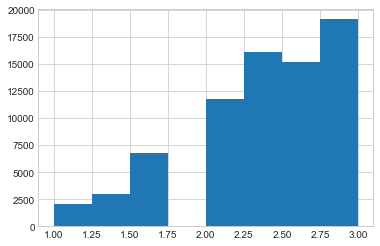

In [59]:
df_train['relevance'].hist(bins=8)

In [60]:
df_train['search_term'].apply(lambda x: len(x.split())).mean()

3.1592072042880095

In [61]:
words_st = ' '.join(df_train['search_term'].values).split()

In [62]:
len(words_st)/5000 * 9.64 / 60

7.518975066666667

In [63]:
len(words_st)/5000 * 32 / 60

24.959253333333333

Okay. That was decent. However, let's work on this and do better!

Attributes wasn't used...I think there must be something here. Also only stems were taken...can we not extract keywords?

In [64]:
df_train['query_len'] = df_train['search_term'].apply(lambda x: len(x.split()))

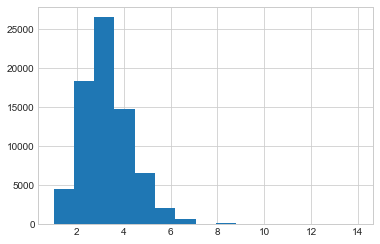

In [65]:
df_train['query_len'].hist(bins=15)

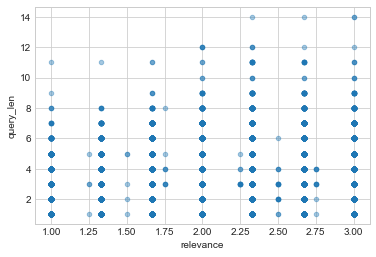

In [66]:
df_train[['query_len','relevance']].plot(kind='scatter', x='relevance', y='query_len', alpha=0.4)

In [67]:
df_train.head(1)

,index,product_uid,product_title,search_term,relevance,product_description,Attributes,query_len
0,0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0,"Not only do angles make joints stronger, they ...",\tVersatile connector for various 90Â° connect...,2


In [68]:
cols = list(df_train.columns)

In [69]:
# I'm Pickle Riiiick!
print('Saving searches...')
searches_nlp = df_train.iloc[:, [cols.index('index'),cols.index('search_term')]]
searches_nlp['search_term'] = searches_nlp['search_term'].apply(nlp_tag)
searches_nlp.to_pickle(data_path+'search_term.pickle')
del searches_nlp

print('Saving titles...')
product_title_nlp = df_train.iloc[:, [cols.index('index'),cols.index('product_title')]]
product_title_nlp['product_title'] = product_title_nlp['product_title'].apply(nlp_tag)
product_title_nlp.to_pickle(data_path+'product_title.pickle')
del product_title_nlp

Saving searches...
Saving titles...


In [70]:
sp = 4
for i in range(1,sp+1):
    print("Saving file {} of {}".format(i,sp))
    product_desc_nlp = df_train.iloc[int((i-1)*len(df_train)/sp):int(i*len(df_train)/sp), [cols.index('index'),cols.index('product_description')]]
    product_desc_nlp['product_description'] = product_desc_nlp['product_description'].apply(nlp_tag)
    product_desc_nlp.to_pickle(data_path+'product_description{}.pickle'.format(str(i)))
    del product_desc_nlp

Saving file 1 of 4
Saving file 2 of 4
Saving file 3 of 4
Saving file 4 of 4


In [71]:
sp = 5
for i in range(1,sp+1):
    print("Saving file {} of {}".format(i,sp))
    attr_nlp = df_train.iloc[int((i-1)*len(df_train)/sp):int(i*len(df_train)/sp), [cols.index('index'),cols.index('Attributes')]]
    attr_nlp['Attributes'] = attr_nlp['Attributes'].apply(nlp_tag)
    attr_nlp.to_pickle(data_path+'attribute{}.pickle'.format(str(i)))
    del attr_nlp

Saving file 1 of 5
Saving file 2 of 5
Saving file 3 of 5
Saving file 4 of 5
Saving file 5 of 5


In [74]:
df_train[['index','relevance']].to_pickle(data_path + 'uid_relevance.pickle')

In [76]:
df_train

,index,product_uid,product_title,search_term,relevance,product_description,Attributes,query_len
0,0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",\tVersatile connector for various 90Â° connect...,2
1,1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",\tVersatile connector for various 90Â° connect...,2
2,2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,"Application Method\tBrush,Roller,Spray\nAssemb...",2
3,3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type\tCombo Tub and Shower\nBuilt-...,3
4,4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type\tCombo Tub and Shower\nBuilt-...,3
5,5,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,3.00,Achieving delicious results is almost effortle...,Appliance Type\tOver the Range Microwave\nAsse...,2
6,6,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwave over stove,2.67,Achieving delicious results is almost effortle...,Appliance Type\tOver the Range Microwave\nAsse...,3
7,7,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,3.00,Achieving delicious results is almost effortle...,Appliance Type\tOver the Range Microwave\nAsse...,1
8,8,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,emergency light,2.67,The Quantum Adjustable 2-Light LED Black Emerg...,Battery Power Type\tNi-Cad\nBattery Size\t.Bui...,2
9,9,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,3.00,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,Application\tDoor & Window\n\tMade of primed M...,2
